<a href="https://colab.research.google.com/github/hechen2020/19ma573HuixinChen/blob/master/src/hw_vasicek_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##hw_vasicek_calibration
###goal: to design pricing engine and calibrate vasicek model from data

##Verify:

$$r_t=r_0e^{-\kappa t}+\mu(1-e^{-\kappa t})+\sigma^{-\kappa t}\int_0^t{e^{\kappa t}dW_s}$$

is the solution for

$$dr_t=\kappa(\mu-r_t)dt+\sigma dW_t$$

with $r_0$

##Steps:

We can first distribute the terms and isolate the terms with $dr_t$ and $r_t$ in the differential equation and get:

$$dr_t+\kappa r_tdt=\kappa\mu+\sigma dW_t$$

Then multiply both sides by the integrating factor $e^{\kappa t}$ and get

$$e^{\kappa t}dr_t+e^{\kappa t}\kappa r_tdt=e^{\kappa t}\kappa\mu+e^{\kappa t}\sigma dW_t$$

note on the left side, if we let $x=r_t$ and $y=e^{\kappa t}$, we should have

$$\frac{dx}{dt} = dr_t = x'$$

$$\frac{dy}{dt} = \kappa e^{\kappa t}dt = y'$$

so the left-hand side becomes

$$x'y+y'x$$

which is equal to $(xy)'$ by property of derivative. So the original differential equation becomes

$$d(e^{\kappa t}r_t) = e^{\kappa t}\kappa\mu+e^{\kappa t}\sigma dW_t$$

We can then integrate both sides to get

$$\int_0^t{d(e^{\kappa s}r_s)}ds = \int_0^t{e^{\kappa s}\kappa\mu+e^{\kappa s}\sigma dW_s}ds$$

where the left-hand side becomes

$$\int_0^t{d(e^{\kappa s}r_s)}ds = e^{\kappa t}r_t - e^0r_0 = e^{\kappa t}r_t - r_0$$

so have

$$e^{\kappa t}r_t - r_0 = \int_0^t{e^{\kappa s}\kappa\mu+e^{\kappa s}\sigma dW_s}ds = \int_0^t{e^{\kappa s}\kappa\mu}ds+\int_0^t{e^{\kappa s}\sigma dW_s}ds$$

On the right-hand side, the first term can be simply integrated as

$$\int_0^t{e^{\kappa s}\kappa\mu}ds = \mu(e^{\kappa t}-1)$$

and in the second term the term $\sigma$ can be pulled out. So we obtain

$$e^{\kappa t}r_t - r_0=\mu(e^{\kappa t}-1)+\sigma\int_0^t{e^{\kappa s}dW_s}ds$$

so

$$r_t = e^{-\kappa t}r_0+e^{-\kappa t}\mu(e^{\kappa t}-1)+e^{-\kappa t}\sigma\int_0^t{e^{\kappa s}dW_s}ds$$

$$r_t = e^{-\kappa t}r_0+\mu(1-e^{-\kappa t})+\sigma e^{-\kappa t}\int_0^t{e^{\kappa s}dW_s}ds$$


###Design pricing engine of ZCB using explicit formula

In [0]:
import numpy as np
import array
import scipy.optimize as so
import matplotlib.pyplot as plt

In [0]:
def zcb_pricing(r0, T, kappa, mu, sigma):
  b = (1-np.exp(-kappa*T))/kappa
  a = (mu - sigma**2/(2*(kappa**2)))*(b-T)-(sigma**2/(4*kappa))*(b**2)
  price = np.exp(a-b*r0)
  
  return price

###Design pricing engine using exact sampling

In [0]:
def zcb_pricing_es(r0, T, kappa, mu, sigma, n):
  
  arr_price = array.array('f',[])
  for i in range(n):
    Z = np.random.normal()
    R = (mu*T + (r0-mu)*((1-np.exp(-kappa*T))/kappa)) + Z*np.sqrt((sigma**2/(2*kappa**3))*(2*kappa*T-3+4*np.exp(-kappa*T)-np.exp(-2*kappa*T)))
    p = np.exp(-R)
    arr_price.append(p)

  return np.mean(arr_price)
  

In [0]:
def zcb_libor(price, T):
  lrate = (100/T)*((1/price)-1)
  
  return lrate

In [132]:
theta = [.1, .05, .003, .03]
kappa, mu, sigma, r0 = theta

T = 1

#using explicit formula
zcb_p1 = zcb_pricing(r0, T, kappa, mu, sigma)
zcb_l1 = zcb_libor(zcb_p1, T)

#using exact sampling with 100 samples
zcb_p2 = zcb_pricing_es(r0, T, kappa, mu, sigma, 100)
zcb_l2 = zcb_libor(zcb_p2, T)

print(zcb_p1)
print(zcb_l1)

print(zcb_p2)
print(zcb_l2)

0.9695084475425054
3.145052787810565
0.96965325
3.1296498259598238


### Find 10 term swap rates

$$s(t, T, N)=100\frac{1-P(t,T)}{\Delta\sum_{j=1}^N{P(t,t+j\Delta)}}$$

$$\Delta=\frac{T-t}{N}$$

In [0]:
def term_swap(r0, T, kappa, mu, sigma, N):
  delta = T/N
  
  arr_p = array.array('f',[])
  for i in range(N):
    p = zcb_pricing(r0, (i+1)*delta, kappa, mu, sigma)
    arr_p.append(p)
    
  swap = 100*((1-zcb_pricing(r0, T, kappa, mu, sigma))/(delta*sum(arr_p)))
    
  return swap

In [0]:
def term_swap_es(r0, T, kappa, mu, sigma, N, num_path):
  delta = T/N
  
  arr_p = array.array('f',[])
  for i in range(N):
    p = zcb_pricing_es(r0, (i+1)*delta, kappa, mu, sigma, num_path)
    arr_p.append(p)
    
  swap = 100*((1-zcb_pricing_es(r0, T, kappa, mu, sigma, num_path))/(delta*sum(arr_p)))
    
  return swap

In [135]:
T = 5
N = 10
swap_rate = term_swap(r0, T, kappa, mu, sigma, N)
swap_rate_es = term_swap_es(r0, T, kappa, mu, sigma, N, 100)
print(swap_rate)
print(swap_rate_es)

3.441821404372335
3.42379027115172


###Callibrate Vasicek model using Libor market data, then compare

In [0]:
import pandas as pd
dfLiborRate = pd.DataFrame({'maturity (months)': [1, 2, 3, 6, 12],
'20081029 rate(%)': [3.1175, 3.2738, 3.4200, 3.4275, 3.4213],
'20110214 rate(%)': [0.2647, 0.2890, 0.3140, 0.4657, 0.7975]
})

In [137]:
dfLiborRate

,20081029 rate(%),20110214 rate(%),maturity (months)
0,3.1175,0.2647,1
1,3.2738,0.2890,2
2,3.4200,0.3140,3
3,3.4275,0.4657,6
4,3.4213,0.7975,12


In [0]:
libor_20081029 = [3.1175, 3.2738, 3.4200, 3.4275, 3.4213]
libor_maturities = [1/12, 2/12, 3/12, 6/12, 1.]

In [0]:
#Using SSRE and explicit formula
def error_fcn(theta, market_rates, maturities):
  kappa, mu, sigma, r0 = theta
  
  arr_e = array.array('f',[])
  for i in range(len(maturities)):
    cal_price = zcb_pricing(r0, maturities[i], kappa, mu, sigma)
    cal_rate = zcb_libor(cal_price, maturities[i])
    err = ((market_rates[i]-cal_rate)/market_rates[i])**2
    arr_e.append(err)
  
  return np.sqrt(np.mean(arr_e))

#Using SSRE and es
def error_fcn_es(theta, market_rates, maturities, num_path):
  kappa, mu, sigma, r0 = theta
  
  arr_e = array.array('f',[])
  for i in range(len(maturities)):
    cal_price = zcb_pricing_es(r0, maturities[i], kappa, mu, sigma, num_path)
    cal_rate = zcb_libor(cal_price, maturities[i])
    err = ((market_rates[i]-cal_rate)/market_rates[i])**2
    arr_e.append(err)
  
  return np.sqrt(np.mean(arr_e))


In [0]:
#Calibration using explicit formula
def lcalibration(libor_rates, maturities):
  init_theta = [.1, .05, .003, .03]
  ikappa, imu, isigma, ir0 = init_theta
  
  return so.fmin(error_fcn, init_theta,
                 args = (libor_rates, maturities), disp = 0)

#Calibration using es
def lcalibration_es(libor_rates, maturities, num_path):
  init_theta = [.1, .05, .003, .03]
  ikappa, imu, isigma, ir0 = init_theta
  
  return so.fmin(error_fcn_es, init_theta, args = (libor_rates, maturities, num_path), disp = 0)

In [141]:
test = error_fcn(theta, libor_20081029,libor_maturities)
print(test)
test2 = error_fcn_es(theta, libor_20081029, libor_maturities, 100)
print(test2)

#calibrated theta using explicit formula
cal_theta = lcalibration(libor_20081029,libor_maturities)
print(cal_theta)
#calibrated theta using es
cal_theta_es = lcalibration_es(libor_20081029,libor_maturities, 100)
print(cal_theta_es)

0.085784964
0.08422754
[ 5.63335603e+02  3.45050192e-02 -8.20930732e+00 -1.14127580e-01]
[0.09771755 0.05207564 0.00289125 0.03273198]


Text(0, 0.5, 'Calibrated rate')

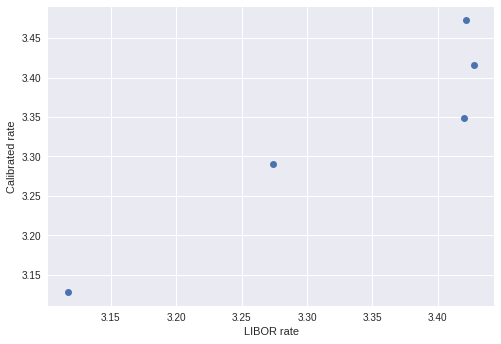

In [142]:
ckappa, cmu, csigma, cr0 = cal_theta

#explicit formula calibration comparison
clibor = array.array('f',[])

for i in range(len(libor_20081029)):
  cprice = zcb_pricing(cr0, libor_maturities[i], ckappa, cmu, csigma)
  cl = zcb_libor(cprice, libor_maturities[i])
  clibor.append(cl)
  
plt.plot(libor_20081029, clibor, 'o')
plt.xlabel('LIBOR rate')
plt.ylabel('Calibrated rate')


Text(0, 0.5, 'Calibrated rate')

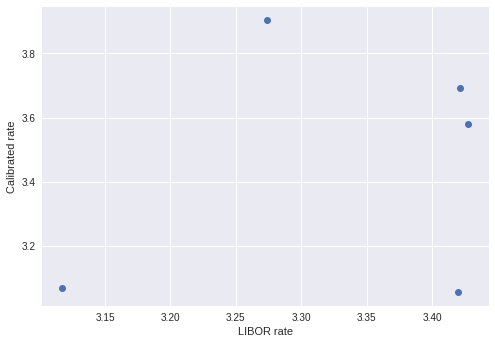

In [143]:
#es calibration comparison: with 100 paths
clibor_es = array.array('f',[])

for i in range(len(libor_20081029)):
  cprice = zcb_pricing_es(cr0, libor_maturities[i], ckappa, cmu, csigma, 100)
  cl = zcb_libor(cprice, libor_maturities[i])
  clibor_es.append(cl)
  
plt.plot(libor_20081029, clibor_es, 'o')
plt.xlabel('LIBOR rate')
plt.ylabel('Calibrated rate')

the pricing engine involving exact sampling produces $\theta$ closer to the initial guess (and more reasonable since the other involve negatives), but explicit formula produces calibrated rates closer to the market rate (and less computational time)

...

###Callibrate Vasicek model using swap market data, then compare

In [0]:
dfSwapRate = pd.DataFrame({'term (year)': [2, 3, 5, 7, 10, 15, 30],
'20081029 rate(%)': [2.6967, 3.1557, 3.8111, 4.1497, 4.3638, 4.3753, 4.2772],
'20110214 rate(%)': [1.0481, 1.5577, 2.5569, 3.1850, 3.7225, 4.1683, 4.4407]
})

In [145]:
dfSwapRate

,20081029 rate(%),20110214 rate(%),term (year)
0,2.6967,1.0481,2
1,3.1557,1.5577,3
2,3.8111,2.5569,5
3,4.1497,3.1850,7
4,4.3638,3.7225,10
5,4.3753,4.1683,15
6,4.2772,4.4407,30


In [0]:
swap_20081029 = [2.6967, 3.1557, 3.8111, 4.1497, 4.3638, 4.3753, 4.2772]
swap_maturity = [2, 3, 5, 7, 10, 15, 30]
#assuming as before the term length is 1/2 year
swap_term = [4, 6, 10, 14, 20, 30, 60]

In [0]:
#Using SSRE and explicit formula
def error_fcn_swap(theta, market_rates, maturities, terms):
  kappa, mu, sigma, r0 = theta
  
  arr_e = array.array('f',[])
  for i in range(len(maturities)):
    cal_rate = term_swap(r0, maturities[i], kappa, mu, sigma, terms[i])
    err = ((market_rates[i]-cal_rate)/market_rates[i])**2
    arr_e.append(err)
  
  return np.sqrt(np.mean(arr_e))

#Using SSRE and es
def error_fcn_swap_es(theta, market_rates, maturities, terms, num_path):
  kappa, mu, sigma, r0 = theta
  
  arr_e = array.array('f',[])
  for i in range(len(maturities)):
    cal_rate = term_swap_es(r0, maturities[i], kappa, mu, sigma, terms[i], num_path)
    err = ((market_rates[i]-cal_rate)/market_rates[i])**2
    arr_e.append(err)
  
  return np.sqrt(np.mean(arr_e))

In [0]:
#Calibration using explicit formula
def scalibration(swap_rates, maturities, terms):
  init_theta = [.1, .05, .003, .03]
  ikappa, imu, isigma, ir0 = init_theta
  
  return so.fmin(error_fcn_swap, init_theta,
                 args = (swap_rates, maturities, terms), disp = 0)

#Calibration using es
def scalibration_es(libor_rates, maturities, terms, num_path):
  init_theta = [.1, .05, .003, .03]
  ikappa, imu, isigma, ir0 = init_theta
  
  return so.fmin(error_fcn_swap_es, init_theta, args = (libor_rates, maturities, terms, num_path), disp = 0)

In [150]:
#calibrated theta using explicit formula
cal_theta_s = scalibration(swap_20081029,swap_maturity, swap_term)
print(cal_theta_s)
#calibrated theta using es
cal_theta_s_es = scalibration_es(swap_20081029,swap_maturity, swap_term, 100)
print(cal_theta_s_es)

[ 1.1858374   0.04717344 -0.02528063 -0.00590252]
[0.09933594 0.05669922 0.00300117 0.02857031]


Text(0, 0.5, 'Calibrated rate')

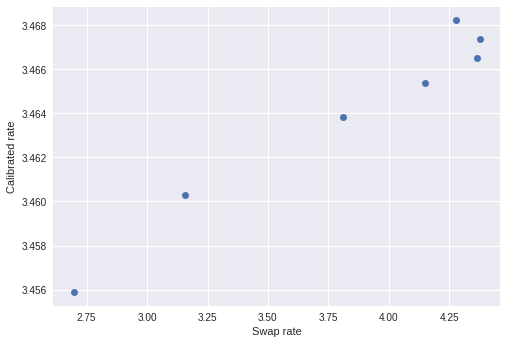

In [151]:
cskappa, csmu, cssigma, csr0 = cal_theta

#explicit formula calibration comparison
cswap = array.array('f',[])

for i in range(len(swap_20081029)):
  cs = term_swap(csr0, swap_maturity[i], cskappa, csmu, cssigma, swap_term[i])
  cswap.append(cs)
  
plt.plot(swap_20081029, cswap, 'o')
plt.xlabel('Swap rate')
plt.ylabel('Calibrated rate')

Text(0, 0.5, 'Calibrated rate')

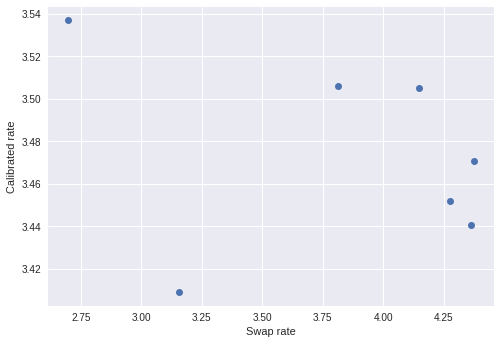

In [152]:
#es calibration comparison: with 100 paths
cswap_es = array.array('f',[])

for i in range(len(swap_20081029)):
#  cprice = zcb_pricing_es(cr0, libor_maturities[i], ckappa, cmu, csigma, 100)
  cs = term_swap_es(csr0, swap_maturity[i], cskappa, csmu, cssigma, swap_term[i], 100)
  cswap_es.append(cs)
  
plt.plot(swap_20081029, cswap_es, 'o')
plt.xlabel('Swap rate')
plt.ylabel('Calibrated rate')

the calibration is better for both methods compared to LIBOR calibration. The explicit formula approach produces rates much closer to those of exact sampling, but the negative $\sigma$ and $r_0$ are still present